In [1]:
import pandas as pd

df = pd.read_csv('../data/sales.csv')
df.dropna(subset=['price'], inplace=True)

In [2]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Random Forest

<font color='red'>Assignment:</font> Build a pipeline with **RandomForestRegressor** to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volumn**.

In [4]:
y_train = train_raw['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))
y_test = test_raw['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))

def weight2num(x):
    """
    This function transform weight string to numerical value.
    """
    if type(x) == str: 
        y = x.split(" Ton ")    
        return float(y[0]) * 1000 + float(y[1].replace(' Kg',''))
    else:
        return x


class Numerical_Transformer(object):
    def fit(self, X, y=None):
        self.mean = {}
        df = pd.DataFrame()        
        df['cost'] = X['cost'].map(lambda x: x if type(x) == float else float(x.strip('$').strip('k'))*1000)
        self.mean['cost'] = df['cost'].mean()
        df['weight'] = X['weight'].map(weight2num)
        self.mean['weight'] = df['weight'].mean()
        df['height'] = X['height'].map(lambda x: x if type(x) == float else float(x.replace('meters', '')))
        self.mean['height'] = df['height'].mean()
        df['width'] = X['width'].map(lambda x: x if type(x) == float else float(x.replace('cm', '')))
        self.mean['width'] = df['width'].mean()
        df['depth'] = X['depth'].map(lambda x: x if type(x) == float else float(x.replace('cm', '')))
        self.mean['depth'] = df['depth'].mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(lambda x: x if type(x) == float else float(x.strip('$').strip('k'))*1000)
        df['weight'] = X['weight'].map(weight2num)
        df['height'] = X['height'].map(lambda x: x if type(x) == float else float(x.replace('meters', '')))
        df['width'] = X['width'].map(lambda x: x if type(x) == float else float(x.replace('cm', '')))
        df['depth'] = X['depth'].map(lambda x: x if type(x) == float else float(x.replace('cm', '')))
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('rfr', RandomForestRegressor(max_depth=3, min_samples_split=5))]

model = Pipeline(steps)

model.fit(train_raw, y_train)


Pipeline(steps=[('ntf',
                 <__main__.Numerical_Transformer object at 0x000001FC94A90BE0>),
                ('norm', StandardScaler()),
                ('rfr',
                 RandomForestRegressor(max_depth=3, min_samples_split=5))])

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [23]:
model.fit(train_raw, y_train)
y_train_pred = model.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.04e+05
train MSE: 2.51e+10
train R2: 0.411
train MAE: 1.30e+05
train MSE: 5.42e+10
train R2: 0.371


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

<BarContainer object of 5 artists>

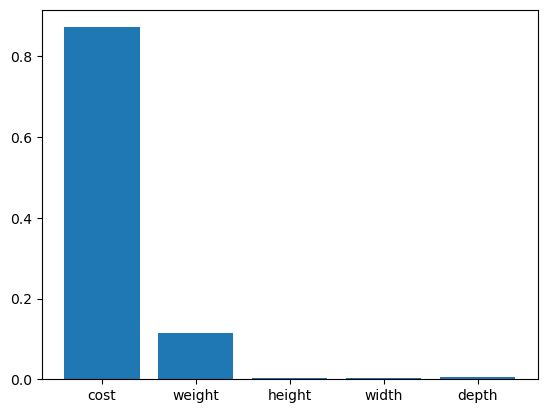

In [24]:
import matplotlib.pylab as plt
%matplotlib inline

plt.bar(['cost','weight','height','width','depth'], model[2].feature_importances_)

<font color='red'>Question:</font> How does Random Forest work? Why is it better than a single decision tree?

In [ ]:
# Random Forest is a way of averaging multiple decision trees. Forests give the effects of k-fold cross-validation. Thus it 
# efficiently prevents overfitting that usually happens when using a single decision tree.

<font color='red'>Question:</font> Why is Random Forest better than a single decision tree? How does it decrease model error? How does it affect bias and virance?

In [ ]:
# Random Forests take the teamwork of many trees thus improving the performance of a single random tree. The technique use 
# bagging (bootstrap aggregating) on the training data set to train multiple decision trees, and use the avearge of all the 
# tree's prediction ot predict the result. Bagging de-correlates the trees by training them with different data set, so while
# the performance of a single tree is sensitive to the noise of the training data set, the average of all trees is not, thus 
# Random Forest decreases model error. It reduces virance while not affect bias.

<font color='red'>Question:</font> What is Bagging?

In [ ]:
# Bagging, or bootstrap aggregating is a data resampling method. It resamples the data with many times, each time resamples the 
# same size of data points from the original data set but with replacement (so some data points may be sampled multiple times, 
# while some data point may not be sampled). 

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=2023)

scorer_method = make_scorer(mean_squared_error, greater_is_better=False)

steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('rfr', RandomForestRegressor())]

model = Pipeline(steps)

model = Pipeline(steps)

n_estimators = [5, 10, 20, 50, 100, 200]
max_depths = range(1, 10)
min_samples_splits = range(2, 5)


grid = dict()
#grid['lr__alpha'] = lasso_alphas 
grid['rfr__n_estimators'] = n_estimators
grid['rfr__max_depth'] = max_depths
grid['rfr__min_samples_split'] = min_samples_splits 


search = GridSearchCV(model, param_grid = grid, scoring = scorer_method, \
                      cv = kf, n_jobs = -1, error_score = np.NaN).fit(train_raw, y_train)

In [27]:
print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -27081263671.25480
Config: {'rfr__max_depth': 3, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 5}


In [28]:
y_train_pred = search.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = search.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.05e+05
train MSE: 2.48e+10
train R2: 0.419
train MAE: 1.31e+05
train MSE: 5.45e+10
train R2: 0.367


In [43]:
steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('rfr', RandomForestRegressor(n_estimators=1000))]

model1 = Pipeline(steps)

model1.fit(train_raw, y_train)
y_train_pred = model1.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model1.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 4.29e+04
train MSE: 4.31e+09
train R2: 0.899
train MAE: 1.29e+05
train MSE: 5.35e+10
train R2: 0.379


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

In [ ]:
# n_estimators should be set big enough to reduce the variance. Surprisingly, when n_estimators is big enough, setting the other
# hyper parameters will increases variance in this case.

# 2. Gradient Boosting Trees

<font color='red'>Assignment:</font> Build a pipeline with **GradientBoostingRegressor** to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volumn**.

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('gbr', GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01))]

model = Pipeline(steps)

model.fit(train_raw, y_train)



Pipeline(steps=[('ntf',
                 <__main__.Numerical_Transformer object at 0x000001FCA3A29E50>),
                ('norm', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.01,
                                           n_estimators=1000))])

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [59]:
model.fit(train_raw, y_train)
y_train_pred = model.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 9.50e+04
train MSE: 2.01e+10
train R2: 0.528
train MAE: 1.26e+05
train MSE: 5.31e+10
train R2: 0.384


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

<BarContainer object of 5 artists>

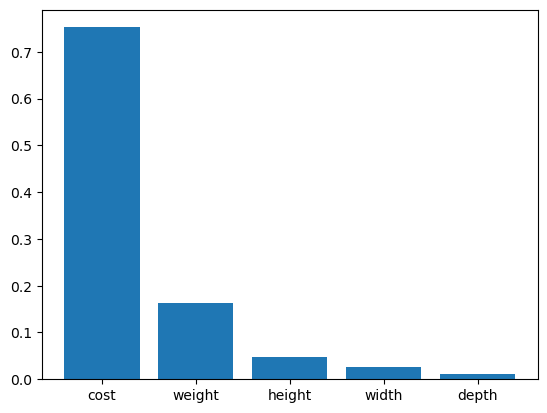

In [60]:
plt.bar(['cost','weight','height','width','depth'], model[2].feature_importances_)

<font color='red'>Question:</font> How does gradient boosting tree work? 

In [ ]:
# Gradient boosting tree weak learners into a strong learner in an iterative fashion.The algorithm repeatly improve the model
# by fitting the risiduals between the previous model prediction and the actual observation value.

<font color='red'>Question:</font> What is boosting?

In [ ]:
# Boosting is a method in machine learning to reduce errors in preditive data analysis. Boosting tries to overcome predicting 
# errors by training multiple models sequentially to improve accuracy of the overall system.

<font color='red'>Question:</font> Compare gradient boosting trees and random forest. What are the pros and cons of these two models?

In [ ]:
# Random forest combines multiple single trees to work simultaneously while gradient boosting trees train the decision trees 
# sequentially. 
# Gradient boosting trees outperform random forest if the hyper parameters are well-tuned. However, it is more difficult to 
# the parameters in Gradient boosting trees. The gradient boosting trees also tend to over-fit when the data is noisy.

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [69]:
kf = KFold(n_splits=5, shuffle=True, random_state=2023)

scorer_method = make_scorer(mean_squared_error, greater_is_better=False)

steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('gbr', GradientBoostingRegressor())]

model = Pipeline(steps)

model = Pipeline(steps)

n_estimators = [5, 10, 20, 50, 100, 200, 500, 1000]
learning_rate = [0.001, 0.01, 0.1, 1]
min_samples_splits = range(2, 10)

grid = dict()
#grid['lr__alpha'] = lasso_alphas 
grid['gbr__n_estimators'] = n_estimators
grid['gbr__learning_rate'] = learning_rate
grid['gbr__min_samples_split'] = min_samples_splits

search = GridSearchCV(model, param_grid = grid, scoring = scorer_method, \
                      cv = kf, n_jobs = -1, error_score = np.NaN).fit(train_raw, y_train)

In [70]:
print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -27562138030.26377
Config: {'gbr__learning_rate': 0.1, 'gbr__min_samples_split': 6, 'gbr__n_estimators': 50}


In [71]:
y_train_pred = search.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = search.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 9.83e+04
train MSE: 2.19e+10
train R2: 0.486
train MAE: 1.26e+05
train MSE: 5.31e+10
train R2: 0.384


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

In [ ]:
# Learning rate and n_estimator can affect model performance. Learning rate control how fast the outcome from each tree will 
# be scaled. n_estimator controls the number of the trees. If the learning rate is small, it takes more n_estimator to train
# the model.

# 3. Xgboost

<font color='red'>Assignment:</font> Build a pipeline with **XGBRegressor** to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volumn**.

In [74]:
conda install -c conda-forge xgboost

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 22.11.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=22.11.1





Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\liyuh\anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    conda-22.11.1              |   py39hcbf5309_1         908 KB  conda-forge
    libxgboost-1.5.0           |       hd77b12b_2         1.3 MB
    py-xgboost-1.5.0           |   py39haa95532_2         156 KB
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    xgboost-1.5.0              |   py39haa95532_2          15 KB
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/win-64::_py-xgboost-mutex-2.0-cpu_0 
  libxgboost         pkgs/

In [77]:
from xgboost import XGBRegressor

steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('xgb', XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1))]

model = Pipeline(steps)

model.fit(train_raw, y_train)


Pipeline(steps=[('ntf',
                 <__main__.Numerical_Transformer object at 0x000001FCDB1537C0>),
                ('norm', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=1,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=2, n_jobs=16, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
            

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [78]:
model.fit(train_raw, y_train)
y_train_pred = model.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.05e+05
train MSE: 2.65e+10
train R2: 0.378
train MAE: 1.31e+05
train MSE: 5.71e+10
train R2: 0.337


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

<BarContainer object of 5 artists>

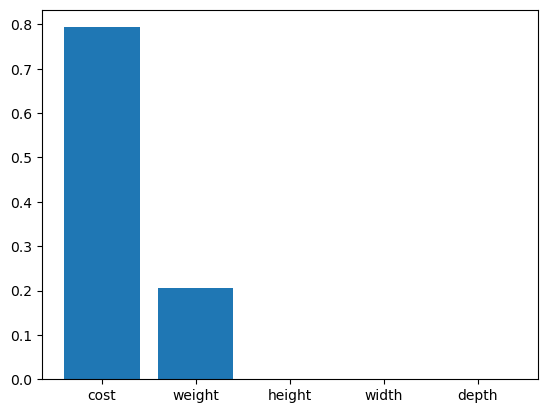

In [79]:
plt.bar(['cost','weight','height','width','depth'], model[2].feature_importances_)

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [88]:
#https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

kf = KFold(n_splits=5, shuffle=True, random_state=2023)

scorer_method = make_scorer(mean_squared_error, greater_is_better=False)

steps = [('ntf', Numerical_Transformer()),
         ('norm', StandardScaler()),
         ('xgb', XGBRegressor())]


model = Pipeline(steps)

gamma = [x*0.1 for x in range(10)]
max_depth = range(1, 8)
min_child_weight = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10]
subsample = [0.3, 0.5, 0.7]

grid = dict()
#grid['lr__alpha'] = lasso_alphas 
grid['xgb__gamma'] = gamma
grid['xgb__max_depth'] = max_depth
grid['xgb__min_child_weight'] = min_child_weight
grid['xgb__subsample'] = subsample

search = GridSearchCV(model, param_grid = grid, scoring = scorer_method, \
                      cv = kf, n_jobs = -1, error_score = np.NaN).fit(train_raw, y_train)

In [89]:
print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -27615090233.68605
Config: {'xgb__gamma': 0.0, 'xgb__max_depth': 1, 'xgb__min_child_weight': 2.0, 'xgb__subsample': 0.5}


In [90]:
y_train_pred = search.predict(train_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = search.predict(test_raw)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.03e+05
train MSE: 2.47e+10
train R2: 0.420
train MAE: 1.26e+05
train MSE: 5.10e+10
train R2: 0.408


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

In [ ]:
# gamma, max_depth, min_child_weight and subsample are important parameters affect model performance. The first three parameters
# control the complexity of the model, while the subsample add randomness in the training to make it robust to noise.

<font color='red'>Question:</font> What is the relationship and difference between Xgboost and gradient boosting trees? Why Xgboost performs better than graident boosting trees?

In [ ]:
# Xgboost is an implement of gradient boosting trees algorithm. Xgboost minimizes a regularized (L1 or L2) objective function. 
# So Xgboost outperforms gradient boosting trees in handling overfitting.